### My first Kaggle competition

It's time! After embarking on a Machine Learning class this semester, and with a Saturday in which I don't have much planned, I wanted to put this class and training to work. It's my first competition submission. I want to walk you guys through how I'm approaching this problem, because I thought it would be really neat. The competition is Banco Santander's [Santander Customer Satisfaction][1] competition. It seemed like an easy enough problem I could actually make decent progress on it.

# Data Exploration

First up: we need to load our data and do some exploratory work. Because we're going to be using this data for model selection prior to testing, we need to make a further split. I've already gone ahead and done this work, please see the code in the [appendix below](#Appendix).

[1]: https://www.kaggle.com/c/santander-customer-satisfaction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Record how long it takes to run the notebook - I'm curious.
from datetime import datetime
start = datetime.now()

dataset = pd.read_csv('split_train.csv')
dataset.index = dataset.ID
X = dataset.drop(['TARGET', 'ID', 'ID.1'], 1)
y = dataset.TARGET

In [2]:
y.unique()

array([0, 1], dtype=int64)

In [3]:
len(X.columns)

369

Okay, so there are only [two classes we're predicting][2]: 1 for unsatisfied customers, 0 for satisfied customers. I would have preferred this to be something more like a regression, or predicting multiple classes: maybe the customer isn't the most happy, but is nowhere near closing their accounts. For now though, that's just the data we're working with.

Now, I'd like to make a scatter matrix of everything going on. Unfortunately as noted above, we have 369 different features. There's no way I can graphically make sense of that much data to start with.

We're also not told what the data actually represents: Are these survey results? Average time between contact with a customer care person? Frequency of contacting a customer care person? The idea is that I need to reduce the number of dimensions we're predicting across.

## Dimensionality Reduction pt. 1 - Binary Classifiers

My first attempt to reduce the data dimensionality is to find all the binary classifiers in the dataset \(i.e. 0 or 1 values\) and see if any of those are good \(or anti-good\) predictors of the final data.

[2]: https://www.kaggle.com/c/santander-customer-satisfaction/data

In [4]:
cols = X.columns
b_class = []
for c in cols:
    if len(X[c].unique()) == 2:
        b_class.append(c)
        
len(b_class)

111

So there are 111 features in the dataset that are a binary label. Let's see if any of them are good at predicting the users satisfaction!

In [5]:
# First we need to `binarize` the data to 0-1; some of the labels are {0, 1},
# some are {0, 3}, etc.
from sklearn.preprocessing import binarize
X_bin = binarize(X[b_class])

accuracy = [np.mean(X_bin[:,i] == y) for i in range(0, len(b_class))]
acc_df = pd.DataFrame({"Accuracy": accuracy}, index=b_class)
acc_df.describe()

,Accuracy
count,111.000000
mean,0.905159
std,0.180602
min,0.043598
25%,0.937329
50%,0.959372
75%,0.960837
max,0.960837


Wow! Looks like we've got some incredibly predictive features! So much so that we should be a bit concerned. My initial guess for what's happening is that we have a sparsity issue: so many of the values are 0, and these likely happen to line up with satisfied customers.

So the question we must now answer, which I likely should have asked long before now: What exactly is the distribution of un/satisfied customers?

In [6]:
unsat = y[y == 1].count()
print("Satisfied customers: {}; Unsatisfied customers: {}".format(len(y) - unsat, unsat))
naive_guess = np.mean(y == np.zeros(len(y)))
print("Naive guess accuracy: {}".format(naive_guess))

Satisfied customers: 51131; Unsatisfied customers: 2083
Naive guess accuracy: 0.9608561656706882


This is a bit discouraging. A naive guess of "always satisfied" performs as well as our best individual binary classifier. What this tells me then, is that these data columns aren't incredibly helpful in prediction. I'd be interested in a polynomial expansion of this data-set, but for now, that's more computation than I want to take on.

# Dimensionality Reduction pt. 2 - LDA

Knowing that our naive guess performs so well is a blessing and a curse:

- Curse: The threshold for performance is incredibly high: We can only "improve" over the naive guess by 4%
- Blessing: All the binary classification features we just discovered are worthless on their own. We can throw them out and reduce the data dimensionality from 369 to 111.

Now, in removing these features from the dataset, I'm not saying that there is no "information" contained within them. There might be. But the only way we'd know is through a polynomial expansion, and I'm not going to take that on within this post.

My initial thought for a "next guess" is to use the [LDA][3] model for dimensionality reduction. However, it can only reduce dimensions to $1 - p$, with $p$ being the number of classes. Since this is a binary classification, every LDA model that I try will have dimensionality one; when I actually try this, the predictor ends up being slightly less accurate than the naive guess.

Instead, let's take a different approach to dimensionality reduction: [principle components analysis][4]. This allows us to perform the dimensionality reduction without worrying about the number of classes. Then, we'll use a [Gaussian Naive Bayes][5] model to actually do the prediction. This model is chosen simply because it doesn't take a long time to fit and compute; because PCA will take so long, I just want a prediction at the end of this. We can worry about using a more sophisticated LDA/QDA/SVM model later.

Now into the actual process: We're going to test out PCA dimensionality reduction from 1 - 20 dimensions, and then predict using a Gaussian Naive Bayes model. The 20 dimensions upper limit was selected because the accuracy never improves after you get beyond that \(I found out by running it myself\). Hopefully, we'll find that we can create a model better than the naive guess.

[3]:http://scikit-learn.org/stable/modules/lda_qda.html
[4]:http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
[5]:http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

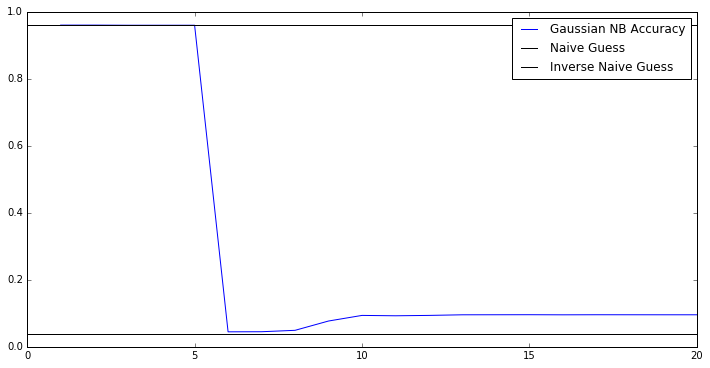

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

X_no_bin = X.drop(b_class, 1)

def evaluate_gnb(dims):
    pca = PCA(n_components=dims)
    X_xform = pca.fit_transform(X_no_bin)
    
    gnb = GaussianNB()
    gnb.fit(X_xform, y)
    return gnb.score(X_xform, y)

dim_range = np.arange(1, 21)
plt.plot(dim_range, [evaluate_gnb(dim) for dim in dim_range], label="Gaussian NB Accuracy")
plt.axhline(naive_guess, label="Naive Guess", c='k')
plt.axhline(1 - naive_guess, label="Inverse Naive Guess", c='k')
plt.gcf().set_size_inches(12, 6)
plt.legend();

\*\*sigh...\*\* After all the effort and computational power, we're still at square one: we have yet to beat out the naive guess threshold. With PCA in play we end up performing terribly, but not terribly enough that we can guess against ourselves.

Let's try one last-ditch attempt using the entire data set:

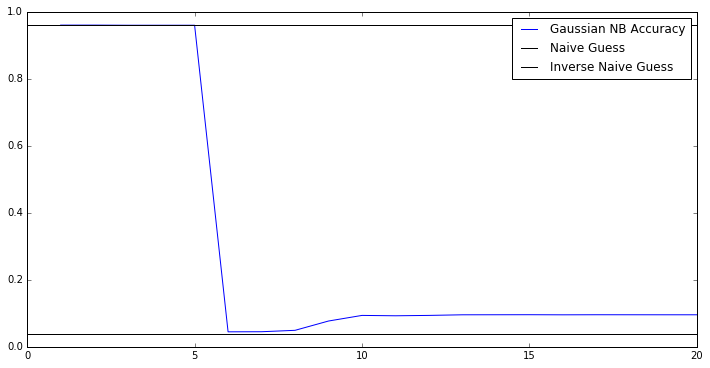

In [8]:
def evaluate_gnb_full(dims):
    pca = PCA(n_components=dims)
    X_xform = pca.fit_transform(X)
    
    gnb = GaussianNB()
    gnb.fit(X_xform, y)
    return gnb.score(X_xform, y)

dim_range = np.arange(1, 21)
plt.plot(dim_range, [evaluate_gnb(dim) for dim in dim_range], label="Gaussian NB Accuracy")
plt.axhline(naive_guess, label="Naive Guess", c='k')
plt.axhline(1 - naive_guess, label="Inverse Naive Guess", c='k')
plt.gcf().set_size_inches(12, 6)
plt.legend();

Nothing. It is interesting to note that the graphs are almost exactly the same: This would imply again that the variables we removed earlier (all the binary classifiers) indeed have almost no predictive power. It seems this problem is high-dimensional, but with almost no data that can actually inform our decisions.

# Summary for Day 1

After spending a couple hours with this dataset, there seems to be a fundamental issue in play: We have very high-dimensional data, and it has no bearing on our ability to actually predict customer satisfaction. This can be a huge issue: it implies that **no matter what model we use, we fundamentally can't perform well.** I'm sure most of this is because I'm not an experienced data scientist. Even so, we have yet to develop a strategy that can actually beat out the village idiot; **so far, the bank is best off just assuming all its customers are satisfied.** Hopefully more to come soon.

In [9]:
end = datetime.now()
print("Running time: {}".format(end - start))

Running time: 0:00:58.715714


# Appendix

Code used to split the initial training data:

```python
from sklearn.cross_validation import train_test_split
data = pd.read_csv('train.csv')
data.index = data.ID

data_train, data_validate = train_test_split(
    data, train_size=.7)

data_train.to_csv('split_train.csv')
data_validate.to_csv('split_validate.csv')
```